# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('./Resources/LoanStats_2019Q1.csv')
ls_df = pd.read_csv(file_path)

# Drop duplicated columns
# Data is pretty much the same
ls_df[['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv']].describe()

,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv
count,68817.000000,68817.000000,68817.000000,68817.000000
mean,16018.845833,16015.919519,970.639473,970.431151
std,10002.695495,10004.985940,1229.563301,1229.569864
min,0.000000,0.000000,0.000000,0.000000
25%,8578.800000,8576.500000,403.760000,403.550000
50%,14067.750000,14061.030000,710.790000,710.790000
75%,22860.700000,22860.490000,1214.600000,1214.590000
max,40000.000000,40000.000000,41418.981165,41418.980000


In [5]:
# Dropping "inv" columns
ls_df.drop(columns={'out_prncp_inv','total_pymnt_inv'}, inplace=True)

# Some data needs to be binary encoded, do that now
from sklearn.preprocessing import LabelEncoder
ls_encoded = pd.get_dummies(ls_df, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan',
                                            'initial_list_status','next_pymnt_d', 'application_type',
                                            'hardship_flag', 'debt_settlement_flag'])

# Preview the data
ls_encoded.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,0,1,1,0,1,1


## Split the Data into Training and Testing

In [6]:
# Create our features
X = ls_encoded.drop(columns="loan_status")

# Create our target
y = pd.DataFrame(ls_encoded["loan_status"])

In [7]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [8]:
# Check the balance of our target values
# HIGHLY imbalanced
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
# Import SKLearn Train-Test-Split model from model selections
from sklearn.model_selection import train_test_split

# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test= train_test_split(X, 
                                                   y, 
                                                   random_state=1, 
                                                   stratify=y)

# Confirm the size of the training data
# with reference to total data, i.e. 68.8k records/rows
X_train.shape

(51612, 93)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [10]:
# Import SKLearn StandardScaler from preprocessing
from sklearn.preprocessing import StandardScaler

# Create the StandardScaler instance
ls_data_scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = ls_data_scaler.fit(X_train)

In [12]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier. For each algorithm, be sure to complete the following steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
#
# Import Balanced Random Forest Classifier from Imbalanced Learn Ensemble lib 
from imblearn.ensemble import BalancedRandomForestClassifier

# Create and fit the Balanced-RF Classifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf_model.fit(X_train_scaled, y_train)

# Perform the prediction
y_pred_rf = brf_model.predict(X_test_scaled)

In [14]:
# Calculate and print the balanced accuracy score
brf_bal_acc = balanced_accuracy_score(y_test, y_pred_rf)
print(f"\nBalanced Accuracy Score: {brf_bal_acc}\n")


Balanced Accuracy Score: 0.8045271966190056



In [15]:
# Display the confusion matrix
brf_cf_matrix = confusion_matrix(y_test, y_pred_rf)
brf_cf_matrix

array([[   63,    24],
       [ 1970, 15148]], dtype=int64)

<AxesSubplot:>

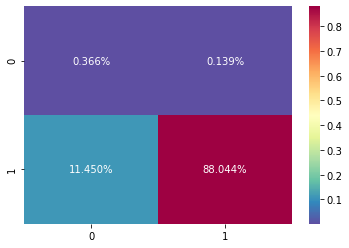

In [16]:
# Now display the confusion matrix a little better :)
import seaborn as sns
sns.heatmap(brf_cf_matrix/np.sum(brf_cf_matrix), annot=True, fmt='.3%', cmap='Spectral_r')

In [17]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_rf, digits=4))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk     0.0310    0.7241    0.8849    0.0594    0.8005    0.6305        87
   low_risk     0.9984    0.8849    0.7241    0.9382    0.8005    0.6511     17118

avg / total     0.9935    0.8841    0.7250    0.9338    0.8005    0.6510     17205



<AxesSubplot:title={'center':'Features Importances\n'}, ylabel='Features'>

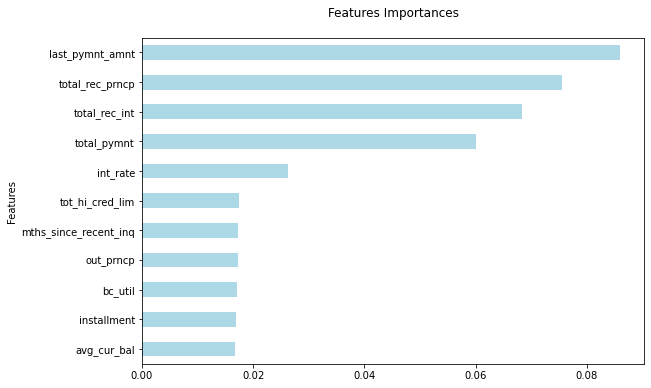

In [18]:
# Calculate and Visualize the features by importance (sorted in descending order)
fi_sorted = sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)

# Create a DataFrame
imp_df = pd.DataFrame(fi_sorted).head(11)

# Set the index and drop that same column 
imp_df.rename(columns={0: 'Feature Importance Rank', 1: 'Features'}, inplace=True)
imp_df.set_index(imp_df["Features"], inplace=True)
imp_df.drop(columns="Features", inplace=True)

# Rename the percentage or rank column (then sort back for the plot)
imp_df.rename(columns={0: 'Feature Importance Rank', 1: 'Features'}, inplace=True)
imp_df = imp_df.sort_values(by='Feature Importance Rank')

# Visualise feature importance
imp_df.plot(kind='barh', color='lightblue', title= 'Features Importances\n', figsize=(9,6), legend=False)


### Easy Ensemble Classifier

In [19]:
# Import the Easy Ensemble Classifier model from Imbalanced Learn
from imblearn.ensemble import EasyEnsembleClassifier

# Train the Classifier
# Create and fit the Easy Ensemble Classifier
eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1, verbose=0)
eec_model.fit(X_train_scaled, y_train)

# Perform the prediction
y_pred_eec = eec_model.predict(X_test_scaled)

In [20]:
# Calculated the balanced accuracy score
# Calculate and print the balanced accuracy score
eec_bal_acc = balanced_accuracy_score(y_test, y_pred_eec)
print(f"\nBalanced Accuracy Score: {eec_bal_acc}\n")


Balanced Accuracy Score: 0.9258362844515352



In [21]:
# Display the confusion matrix
# Display the confusion matrix
eef_cf_matrix = confusion_matrix(y_test, y_pred_eec)
eef_cf_matrix

array([[   79,     8],
       [  965, 16153]], dtype=int64)

<AxesSubplot:>

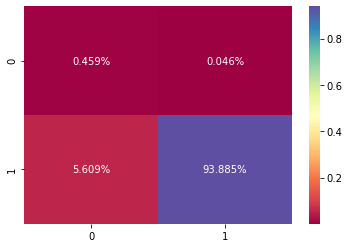

In [22]:
# Now display the confusion matrix a little better :)
import seaborn as sns
sns.heatmap(eef_cf_matrix/np.sum(eef_cf_matrix), annot=True, fmt='.3%', cmap='Spectral')

In [23]:
# Print the imbalanced classification report
eec_cl_report = classification_report_imbalanced(y_test, y_pred_eec, digits=4)
print(eec_cl_report)

                   pre       rec       spe        f1       geo       iba       sup

  high_risk     0.0757    0.9080    0.9436    0.1397    0.9257    0.8538        87
   low_risk     0.9995    0.9436    0.9080    0.9708    0.9257    0.8599     17118

avg / total     0.9948    0.9434    0.9082    0.9666    0.9257    0.8599     17205



In [25]:
# Print all Balanced Accuracy Scores for easy reference ...
#
print("          All Balanced Accuracy Scores\n----------------------------------------------------------")
print(f"Simple Scaled - Balanced Random Forest: {brf_bal_acc}")
print(f"         Simple Scaled - Easy Ensemble: {eec_bal_acc}")

          All Balanced Accuracy Scores
----------------------------------------------------------
Simple Scaled - Balanced Random Forest: 0.8045271966190056
         Simple Scaled - Easy Ensemble: 0.9258362844515352


### Final Questions

1. Which model had the best balanced accuracy score?

   **Answer:**  
   The model with the most balanced accuracy was that gained using the Easy Ensemble Classifier.  

2. Which model had the best recall score?

   **Answer:**  
   The model with the best recall score is the Easy Ensemble model based on the average (and f1-score)!
   
| Classification model | Avg. f1 | high_risk | low_risk | Avg. Recall | Best
| -: | :-: | :-: | :-: | :-: | :-:
| Balanced Random Forest | 0.9338 | 0.7241 | 0.8849 | 0.8841
| Easy Ensemble | 0.9666 | 0.9080| 0.9436 | 0.9434 | X

3. Which model had the best geometric mean score?

   **Answer:**  
   Similarly, the model with the best geometric mean is the Easy Ensemble model.

| Classification model | Geometric Mean | Best
| -: | :- | :-:
| Balanced Random Forest | 0.8005
| Easy Ensemble | 0.9257 | X

4. What are the top three features?

   **Answer:**  
   The top 3 features (out of 93 features evaluated), starting with the most significant, are: -
   * Last Payment Amount (last_pymnt_amnt) at 8.6%
   * Total Principal Received (total_rec_prncp) at 7.6%
   * Total Interest Received (total_rec_int) at 6.8%
   
    